### Figure 1

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHub/sd_paper/analysis_and_figure_code/DataPaths/'])

import matplotlib.pyplot as plt
import numpy as np
import subjects
import pandas as pd
import seaborn as sns
import scipy.signal as sg
from tqdm import tqdm
from neuropy import plotting
from neuropy.utils.misc import flatten
from scipy import stats
from plotters import Plotter, get_nsd_vs_sd_df, add_parametric_extras, stats_to_df, filter_stats_df
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

grpdata = subjects.GroupData()

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### EDF1: Delta spectrogram + hypnogram plots for all animals
See `sd_figure3.ipynb`.
- Note that this requires access to raw .eeg file - contact authors if needed.

### 1B: Slow oscillation (1-10 Hz) spectrogram
- Ognjanovski et al. 2018 reported increased delta and decreased theta during sleep deprivation. However, I am seeing the opposite.
- See `sd_figure3.ipynb` for plots of all animals - companion plot to ExtendedFig1 (EV plots)
- Note that this requires access to raw .eeg files - contact authors if needed.

In [2]:
from neuropy.core import Signal
from scipy.ndimage import gaussian_filter1d
from neuropy.utils import signal_process

smooth = lambda x: gaussian_filter1d(x, sigma=60 / 4)
sessions = subjects.nsd.ratVday1 + subjects.sd.ratVday2
time_all, brainstates, spect_all = [], [], []
for sess in sessions:
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    t_start = pre[0]
    t_stop = post[0] + 7.5 * 3600

    # Chan 191 was used for ratUDay2 and ratUDay4
    # signal = sess.eegfile.get_signal(191, t_start=t_start, t_stop=t_stop)
    chan = sess.best_channels.slow_wave
    signal = sess.eegfile.get_signal(chan, t_start=t_start, t_stop=t_stop)
    trace = signal.traces[0].astype("int16")

    if sess.artifact is not None:
        for e in sess.artifact.as_array():
            indx = (signal.time >= e[0]) & (signal.time <= e[1])
            trace[indx] = 1e-16

    signal = Signal(trace[np.newaxis, :], sampling_rate=1250, t_start=signal.t_start)
    spect = signal_process.FourierSg(signal, window=4, overlap=0, norm_sig=False)
    sxx = spect.freq_slice(1.5, 10).traces

    post_indx = (spect.time >= post[0]) & (spect.time <= t_stop)
    time_all.append(spect.time[post_indx])
    spect_all.append(sxx[:, post_indx])

    brainstates.append(sess.brainstates.time_slice(t_start, t_stop))

t_stop > stop time of first epoch, reassigned to match last epoch stop time
t_stop > stop time of first epoch, reassigned to match last epoch stop time


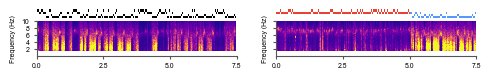

In [3]:
from neuropy.plotting import plot_epochs, plot_hypnogram
from neuropy.core import Epoch
from neuropy import plotting
from hfuncs import merge_quiet_wake

combine_wake = False
wake_append = "" if combine_wake else "_split_wake"
state_bin_size = 30 # seconds, 1 is default

fig = subjects.SdFig().fig1(18, 12)
subfig = fig.add_subfigure(fig.gs[0, :8])
axs = subfig.subplots(
    2, 2, sharex=True, sharey=True, gridspec_kw=dict(height_ratios=[1, 4], hspace=0.1)
)
# _, axs = plt.subplots(
#     2, 2, sharey="row", sharex="col", gridspec_kw=dict(height_ratios=[2, 1])
# )

for i in range(2):
    time = time_all[i]
    sxx = spect_all[i]
    post_t = np.arange(time[0], time[-1] + 10, 2.5 * 3600)
    zt_time = np.round(((post_t - time[0]) / 3600), 2)

    ax = axs[0, i]
    states = brainstates[i]

    # Change resolution
    if state_bin_size > 1:
        states = states.resample_labeled_epochs(state_bin_size, t_start=time[0], t_stop=time[-1], merge_neighbors=True)
        bin_append = f"_statebin{state_bin_size}"
        
    if combine_wake: # Combine wake states
        wk_states = states.label_slice(["AW", "QW"]).set_labels("WK").merge_neighbors()
        labels_order = ["NREM", "REM", "WK"]
    else: # Keep states split
        wk_states = states.label_slice(["AW", "QW"])
        labels_order = ["NREM", "REM", "QW", "AW"]
    slp_states = states.label_slice(["NREM", "REM"])
    all_states = slp_states + wk_states
    # Plot hypnogram
    sd_color = subjects.colors_sd(1)[1]
    rs_color = subjects.colors_rs(1)[0]
    grp = "NSD" if ("NSD" in str(sessions[i])) else "SD"
    colors = "k" if grp == "NSD" else {"SD": sd_color, "RS": rs_color}
    colorby = "label" if grp == "NSD" else "exp_stage"
    if grp == "SD":
        exp_stage = np.ones_like(all_states.labels)
        exp_stage[all_states.starts < (time[0] + 5 * 3600)] = "SD"
        exp_stage[all_states.starts >= (time[0] + 5 * 3600)] = "RS"
        all_states = all_states.add_column("exp_stage", exp_stage)
    plot_epochs(
        all_states,
        ax=ax,
        labels_order=labels_order,
        colors=colors,
        colorby=colorby,
        # colors=k,
        collapsed=False,
    )
    ax.set_xticks(post_t, zt_time)
    ax.set_axis_off()

    ax = axs[1, i]
    # ax = fig.subplot(fig.gs[:2,2*i:2*i+3])
    ax.imshow(
        # sxx*100,
        stats.zscore(sxx, axis=None),
        aspect="auto",
        cmap="plasma",
        vmax=1.3,
        origin="lower",
        extent=[time[0], time[-1], 1.5, 10],
    )
    ax.set_ylabel("Frequency (Hz)")
    ax.set_yticks([2, 4, 6, 8, 10])
    # axs[0,i].set_ylim(1.5,10)
    # ax.plot(time, theta_all[i]*100,'k')
    ax.set_xticks(post_t, zt_time)
    # ax.set_xticks([0, 2.5, 5.0, 7.5])

    # ax2 = axs[1,i].twinx()
    # ax2.plot(time, delta_all[i]*100,'r')
    # axs[1,i].set_xlim(left=time[0])
    # x_ticks = axs[1, i].get_xticks()
    # new_xticks = (x_ticks - time_all[i][0]) / 3600
    # axs[1,i].set_ylabel('Theta power\n(% session mean)')
    # axs[1,i].set_ylim(30,350)
    # axs[1,i].set_xticks(x_ticks,new_xticks.round(2))

fig.savefig(subjects.figpath_sd / f"sd_fig1_delta_theta_spect{wake_append}{bin_append}", dpi=300, format="svg")

#### Sanity check code to make sure epoch resampling is working correctly
Note that due to the way imshow plots things, the minimum resolution of the epochs might appear to be off if you zoom in in the pdfs.

In [48]:
# Resample
all_states_rs_check = states.resample_labeled_epochs(4, t_start=time[0], t_stop=time[-1], merge_neighbors=False)
all_states_rs_check

t_stop > stop time of first epoch, reassigned to match last epoch stop time


6743 epochs
Snippet: 
          start         stop label
0  13367.32448  13371.32448    QW
1  13371.32448  13375.32448    QW
2  13375.32448  13379.32448    QW
3  13379.32448  13383.32448    QW
4  13383.32448  13387.32448    QW

<Axes: >

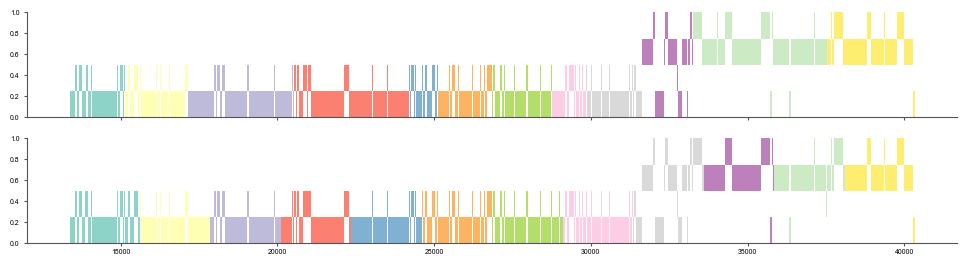

In [50]:
# Plot - looks like it matches
_, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 3))
plotting.plot_epochs(epochs=all_states.time_slice(time[0], time[-1]), ax=ax[0])
plotting.plot_epochs(epochs=all_states_rs_check, ax=ax[1])

### 1C: Slow wave / theta power spectrum across SD
- Note that this requires access to raw .eeg file - contact authors if needed.

In [194]:
session_list = [subjects.nsd.brainstates_sess, subjects.sd.brainstates_sess]

psd_df = []
for sessions in session_list:
    for s, sess in enumerate(tqdm(sessions)):
        fs = sess.eegfile.sampling_rate
        # epochs = sess.get_zt_epochs(include_pre=False, include_maze=False)
        post = sess.paradigm["post"].flatten()
        starts = np.array([post[0], post[0] + 2.5 * 3600, post[0] + 5 * 3600])
        zt_epochs = sess.paradigm.from_array(starts, starts + 2.5 * 3600, ["ZT 0-2.5", "ZT 2.5-5", "ZT 5-7.5"])
        sess.ripple.metadata["channels"][3]5
    
        for e in zt_epochs.itertuples():
            trace = sess.eegfile.get_signal(channel, e.start, e.stop).traces[0]
            f, pxx = sg.welch(trace, fs=fs, nperseg=4 * fs, noverlap=0)
            pxx = pxx * (0.95 * 1e-3) ** 2
            psd_df.append(pd.DataFrame(dict(zt=e.label, f=f, pxx=pxx, grp=sess.tag)))

psd_df = pd.concat(psd_df, ignore_index=True)

100%|█████████████████████████████████████████████| 6/6 [04:22<00:00, 43.75s/it]


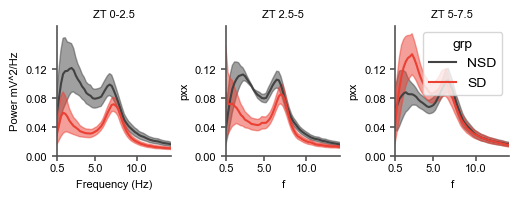

In [202]:
fig = plotting.Fig(8, 6)

colors = subjects.colors_sd(1)
shading_colors = subjects.colors_sd_light(1.7)

nsesh = np.array([len(sessions) for sessions in session_list])
for i, zt_use in enumerate(["ZT 0-2.5", "ZT 2.5-5", "ZT 5-7.5"]):
    
    ax = fig.subplot(fig.gs[0, i])
    df_use = psd_df[psd_df.zt == zt_use]

    df_grp = df_use.drop(columns="zt").groupby(["grp", "f"])
    mean_prob = df_grp.mean(numeric_only=True).reset_index()
    sem_prob = df_grp.sem(ddof=0, numeric_only=True).reset_index()
    legend_flag = False if i != 2 else True
    # sns.lineplot(data=df_use, x="f", y="pxx", hue="grp", palette=subjects.colors_sd(1), legend=legend_flag, ci=None)
    sns.lineplot(data=mean_prob, x="f", y="pxx", hue="grp", palette=colors, legend=legend_flag, ci=None)
    for shade_color, grp in zip(colors, ["NSD", "SD"]):
        sem_use = sem_prob[sem_prob.grp == grp]
        mean_use = mean_prob[mean_prob.grp == grp]
        ax.fill_between(mean_use.f, mean_use.pxx - sem_use.pxx, mean_use.pxx + sem_use.pxx, color=shade_color, alpha=0.5)
    ax.set_xlim([0.5, 14])
    ax.set_xticks([0.5, 5.0, 10.0])
    ax.set_yticks([0.00, 0.04, 0.08, 0.12])
    ax.set_ylim([0, 0.18])
    if i == 0:
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Power mV^2/Hz")

    ax.set_title(zt_use)

fig.savefig(subjects.figpath_sd / f"sd_fig1_delta_theta_psd", dpi=300, format="svg")
            

### 1F: Spectrogram in the ripple band showing ripple frequency and power changes NSD vs SD
- Note that this requires access to raw .eeg file - contact authors if needed.

In [2]:
from neuropy.utils.signal_process import FourierSg, filter_sig

sessions = subjects.nsd.ratVday1 + subjects.sd.ratVday2

ripple_spects = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 7.5 * 3600]
    rpl_df = sess.ripple.time_slice(*period).to_dataframe()
    signal = sess.eegfile.get_signal(82).time_slice(None, *period)
    signal = filter_sig.bandpass(signal, lf=125, hf=250)
    # signal = whiten_signal(signal)
    spect = FourierSg(signal, window=4, overlap=2).freq_slice(125, 250)
    ripple_spects.append(
        dict(
            sxx=spect,
            time=rpl_df.start.values,
            freq=rpl_df.peak_frequency_bp,
            states=sess.brainstates.time_slice(*period),
        )
    )

t_start < start time of first epoch, reassigned to match first epoch start time
t_start < start time of first epoch, reassigned to match first epoch start time
t_stop > stop time of first epoch, reassigned to match last epoch stop time


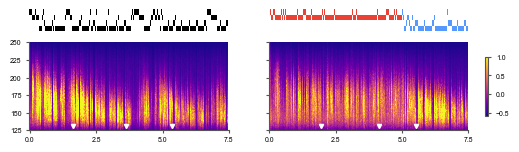

In [9]:
from hfuncs import merge_quiet_wake
from neuropy.plotting import plot_epochs, plot_hypnogram
from neuropy.core import Epoch
from neuropy import plotting
from hfuncs import merge_quiet_wake

plot_mean_fr = False
combine_wake = False
wake_append = "" if combine_wake else "_split_wake"
state_bin_size = 30
fr_append = "" if plot_mean_fr else "_no_mean_line"

fig = subjects.SdFig().fig1(7, 12)
subfig = fig.add_subfigure(fig.gs[0, :8])
axs = subfig.subplots(
    2, 2, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True, sharey="row"
)
# _, axs = plt.subplots(9,12)
example_ripple_timepoints = [
    [1.66, 3.65, 5.39],
    [1.93, 4.14, 5.51],
]  # selected from example rippples cells

for i, spect in enumerate(ripple_spects):
    sxx = spect["sxx"]
    time = spect["time"]
    post_t = np.arange(sxx.time[0], sxx.time[-1] + 5, 2.5 * 3600)
    zt_time = (post_t - sxx.time[0]) / 3600

    ax = axs[0, i]
    # brainstates = spect["states"]
    states = spect["states"]
   # Change resolution
    if state_bin_size > 1:
        states = states.resample_labeled_epochs(state_bin_size, t_start=time[0], t_stop=time[-1], merge_neighbors=True)
        bin_append = f"_statebin{state_bin_size}"
        
    if combine_wake: # Combine wake states
        wk_states = states.label_slice(["AW", "QW"]).set_labels("WK").merge_neighbors()
        labels_order = ["NREM", "REM", "WK"]
    else: # Keep states split
        wk_states = states.label_slice(["AW", "QW"])
        labels_order = ["NREM", "REM", "QW", "AW"]
    slp_states = states.label_slice(["NREM", "REM"])
    all_states = slp_states + wk_states
    # Plot hypnogram
    sd_color = subjects.colors_sd(1)[1]
    rs_color = subjects.colors_rs(1)[0]
    grp = "NSD" if ("NSD" in str(sessions[i])) else "SD"
    colors = "k" if grp == "NSD" else {"SD": sd_color, "RS": rs_color}
    colorby = "label" if grp == "NSD" else "exp_stage"
    if grp == "SD":
        exp_stage = np.ones_like(all_states.labels)
        exp_stage[all_states.starts < (time[0] + 5 * 3600)] = "SD"
        exp_stage[all_states.starts >= (time[0] + 5 * 3600)] = "RS"
        all_states = all_states.add_column("exp_stage", exp_stage)
    plot_epochs(
        all_states,
        ax=ax,
        labels_order=labels_order,
        colors=colors,
        colorby=colorby,
        collapsed=False,
    )
    ax.set_xticks(post_t, zt_time)
    ax.set_axis_off()

    ax = axs[1, i]
    im = ax.imshow(
        stats.zscore(sxx.traces, axis=None),
        aspect="auto",
        # vmin=-0.,
        vmax=1,
        cmap="plasma",
        # norm=mcolors.LogNorm(0.0000001,0.07),
        origin="lower",
        extent=[sxx.time[0], sxx.time[-1], sxx.freqs[0], sxx.freqs[-1]],
    )

    rpl_t = np.array(example_ripple_timepoints[i]) * 3600 + sxx.time[0]
    ax.plot(rpl_t, [132, 132, 132], "v", color="w", markersize=3)

    mov_window = (1 / 20) * np.ones(20)
    if plot_mean_fr:
        ax.plot(
            spect["time"], np.convolve(spect["freq"], mov_window, mode="same"), "k", lw=0.2
        )
    ax.set_ylim(125, 250)
    ax.set_xticks(post_t, zt_time)

ax = ax.inset_axes([1, 0, 0.1, 1])
plt.colorbar(im, ax=ax)
ax.set_axis_off()
fig.savefig(subjects.figpath_sd / f"sd_fig1_ripple_spect{wake_append}{bin_append}{fr_append}", dpi=300, format="svg")

### 1E: Ripple across multiple shanks and unit activity
- Note that this requires access to raw .eeg file - contact authors if needed.

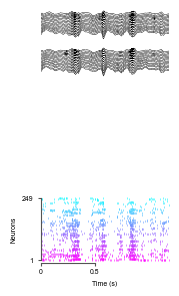

In [10]:
from neuropy.utils.signal_process import filter_sig

# Inkscape has certain issues if you have rasterized image plotted with vector graphics. So here I am generating two separte figures, ripple traces and raster axes as pdf file
fig = subjects.SdFig().fig1(23, 25)

sess = subjects.nsd.ratUday2[0]
sw_amp = sess.ripple.to_dataframe()["sharp_wave_amp"]
# indx = np.random.choice(np.where(sw_amp>3)[0])

indx = 11015
selected_rippls = sess.ripple[indx : indx + 3].flatten()
period = [selected_rippls[0] - 0.5, selected_rippls[-1] - 0.5]
channels = sess.recinfo.channel_groups[6].astype("int")
signal = sess.eegfile.get_signal(channels, *period)
filt_signal = filter_sig.bandpass(signal, lf=2, hf=30)

for i in range(2):
    channels = sess.recinfo.channel_groups[i + 6].astype("int")
    signal = sess.eegfile.get_signal(channels, *period)
    ax = fig.subplot(fig.gs[i, :5])
    # ax=axs[i]
    plotting.plot_signal_traces(signal, ax=ax, pad=0.36, color="k", lw=0.3)
    ax.set_xlim(signal.t_start, signal.t_stop)
    ax.axis("off")
    # ax[i].set_facecolor('k')

ax = fig.subplot(fig.gs[5:7, :5])
# ax = axs[4:]
neurons = sess.neurons_stable.time_slice(*period)
plotting.plot_raster(
    neurons,
    ax=ax,
    color="cool_r",
    markersize=0.8,
    markeredgewidth=0.4,
    rasterized=True,
    # add_vert_jitter=True,
)

# ax.axhline(2, period[0], period[0] + 0.5, color="k")
ax.set_xticks(np.arange(0, 1, 0.5) + period[0], [0, 0.5])
ax.set_yticks([0, 248], [1, 249])
# ax.spines["left"].set_bounds(1, 249)
# ax.spines["right"].set_bounds(1, 249)
fig.trim_spines(ax)


fig.savefig(subjects.figpath_sd / "sd_fig1_swr_examples", dpi=300, format="svg")

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

ZT 0-2.5_NSD vs. ZT 0-2.5_SD: Welch's t-test independent samples, P_val:8.189e-01 t=2.364e-01
PRE_NSD vs. PRE_SD: Welch's t-test independent samples, P_val:9.482e-01 t=-6.613e-02
ZT 2.5-5_NSD vs. ZT 2.5-5_SD: Welch's t-test independent samples, P_val:1.078e-03 t=-4.108e+00
ZT 5-7.5_NSD vs. ZT 5-7.5_SD: Welch's t-test independent samples, P_val:6.704e-01 t=-4.388e-01
ZT 0-2.5_NSD vs. ZT 5-7.5_SD: Welch's t-test independent samples, P_val:7.871e-03 t=3.350e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 5.00e-02 < p <= 5.00e-02
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

ZT 2.5-5_NSD vs. ZT 5-7.5_NSD: t-test paired samples, P_val:1.175e-01 t=1.785e+00
PRE_NSD vs. ZT 0-2.5_NSD: t-test paired samples, P_val:1.489e-01 t=-1.6

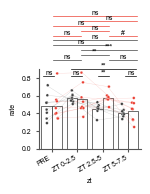

In [7]:
fig = subjects.SdFig().fig1()
rpl_rate = grpdata.ripple_rate
rpl_rate = rpl_rate[rpl_rate.zt != "MAZE"]
ax = fig.subplot(fig.gs[0, 2:4])
plotter = Plotter(
    data=rpl_rate, x="zt", y="rate", hue="grp", hue_order=["NSD", "SD"], ax=ax
)
# plotter.violinplot_sd(split=True, palette=subjects.colors_sd(1)).stat_anot_sd(
#     stat_across=get_bootstrap_prob,
#     stat_within=get_bootstrap_prob_paired,
#     alpha_within=0.025,
#     alpha_across=0.025,
#     fontsize=5,
# )
results_list = []
results_list.append(plotter.stripbarlineplot_sd(palette=subjects.colors_sd(1)).stat_anot_sd(
    stat_across="t-test_welch",
    stat_within="t-test_paired",
    alpha_within=[0.05, 0.01, 0.001],
    alpha_across=[0.05, 0.01, 0.001],
    fontsize=5,
    verbose=True,
))

fig.savefig(subjects.figpath_sd / "sd_fig1_ripple_rate", format="svg")

In [10]:
results_df = stats_to_df(results_list)
results_df = add_parametric_extras(rpl_rate, results_df, "rate")
# filter_stats_df(results_df, figure="1")
results_df

Index(['rate', 'zt', 'session', 'name', 'grp'], dtype='object')


,comp1,comp2,test,pval,test_stat,CI95%,Cohen's-d,dof
0,ZT 0-2.5_NSD,ZT 0-2.5_SD,Welch's,8.189e-01,2.364e-01,"[-0.13, 0.16]",0.118187,8.217437
1,PRE_NSD,PRE_SD,Welch's,9.482e-01,-6.613e-02,"[-0.17, 0.16]",0.033065,13.568408
2,ZT 2.5-5_NSD,ZT 2.5-5_SD,Welch's,1.078e-03,-4.108e+00,"[-0.19, -0.06]",2.054032,13.917303
3,ZT 5-7.5_NSD,ZT 5-7.5_SD,Welch's,6.704e-01,-4.388e-01,"[-0.12, 0.08]",0.219414,9.725033
4,ZT 0-2.5_NSD,ZT 5-7.5_SD,Welch's,7.871e-03,3.350e+00,"[0.05, 0.25]",1.674974,9.528999
5,ZT 2.5-5_NSD,ZT 5-7.5_NSD,t-test,1.175e-01,1.785e+00,"[-0.01, 0.1]",0.791162,7.000000
6,PRE_NSD,ZT 0-2.5_NSD,t-test,1.489e-01,-1.622e+00,"[-0.23, 0.04]",0.891397,7.000000
7,ZT 0-2.5_NSD,ZT 2.5-5_NSD,t-test,1.860e-03,4.848e+00,"[0.06, 0.18]",2.260965,7.000000
8,ZT 0-2.5_NSD,ZT 5-7.5_NSD,t-test,2.210e-06,1.403e+01,"[0.14, 0.2]",3.309108,7.000000
9,PRE_NSD,ZT 2.5-5_NSD,t-test,6.766e-01,4.351e-01,"[-0.13, 0.19]",0.275266,7.000000


In [11]:
rpl_rate.groupby(["grp", "zt"]).aggregate(
    ["mean", "median", lambda x: x.quantile(0.75) - x.quantile(0.25)])

/tmp/ipykernel_338503/3654468141.py:1: FutureWarning: ['name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  rpl_rate.groupby(["grp", "zt"]).aggregate(


rate                      session                  
                  mean    median <lambda_0>    mean median <lambda_0>
grp zt                                                               
NSD PRE       0.481480  0.482176   0.152316     3.5    3.5        3.5
    ZT 0-2.5  0.575417  0.569222   0.065556     3.5    3.5        3.5
    ZT 2.5-5  0.451792  0.458167   0.029639     3.5    3.5        3.5
    ZT 5-7.5  0.407792  0.398722   0.043389     3.5    3.5        3.5
SD  PRE       0.486606  0.431556   0.158556    11.5   11.5        3.5
    ZT 0-2.5  0.560806  0.503722   0.164139    11.5   11.5        3.5
    ZT 2.5-5  0.578583  0.570389   0.027694    11.5   11.5        3.5
    ZT 5-7.5  0.427319  0.450667   0.187222    11.5   11.5        3.5

### 1D: Delta waves rate

In [4]:
rpl_rate = grpdata.delta_wave_rate
rpl_rate = rpl_rate[rpl_rate.zt != "MAZE"]
rpl_rate.drop(columns="session").groupby(["grp", "zt"]).aggregate(
    ["mean", "median", lambda x: x.quantile(0.75) - x.quantile(0.25)]
).reset_index()

grp        zt delta_rate                     
                       mean    median <lambda_0>
0  NSD       PRE   0.122303  0.089262   0.150333
1  NSD  ZT 0-2.5   0.534250  0.534722   0.226306
2  NSD  ZT 2.5-5   0.606042  0.633389   0.178861
3  NSD  ZT 5-7.5   0.423931  0.423833   0.068806
4   SD       PRE   0.155672  0.152500   0.121699
5   SD  ZT 0-2.5   0.153917  0.129889   0.107389
6   SD  ZT 2.5-5   0.216917  0.231944   0.118306
7   SD  ZT 5-7.5   0.925139  0.931889   0.230056

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

ZT 0-2.5_NSD vs. ZT 0-2.5_SD: Welch's t-test independent samples, P_val:2.960e-03 t=4.139e+00
PRE_NSD vs. PRE_SD: Welch's t-test independent samples, P_val:5.216e-01 t=-6.574e-01
ZT 2.5-5_NSD vs. ZT 2.5-5_SD: Welch's t-test independent samples, P_val:5.764e-04 t=5.273e+00
ZT 5-7.5_NSD vs. ZT 5-7.5_SD: Welch's t-test independent samples, P_val:3.164e-06 t=-7.712e+00
ZT 0-2.5_NSD vs. ZT 5-7.5_SD: Welch's t-test independent samples, P_val:2.596e-03 t=-3.842e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 5.00e-02 < p <= 5.00e-02
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

ZT 2.5-5_NSD vs. ZT 5-7.5_NSD: t-test paired samples, P_val:2.755e-02 t=2.774e+00
PRE_NSD vs. ZT 0-2.5_NSD: t-test paired samples, P_val:5.701e-04 t=-5.9

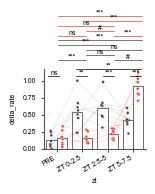

In [5]:
fig = subjects.SdFig().fig1()
delta_rate = grpdata.delta_wave_rate
delta_rate = delta_rate[delta_rate.zt != "MAZE"]
ax = fig.subplot(fig.gs[0, 2:4])
plotter = Plotter(
data=delta_rate, x="zt", y="delta_rate", hue="grp", hue_order=["NSD", "SD"], ax=ax,
)
# plotter.violinplot_sd(split=True, palette=subjects.colors_sd(1)).stat_anot_sd(
#     stat_across=get_bootstrap_prob,
#     stat_within=get_bootstrap_prob_paired,
#     alpha_within=0.025,
#     alpha_across=0.025,
#     fontsize=5,
# )

results_list = []
results_list.append(plotter.stripbarlineplot_sd(palette=subjects.colors_sd(1)).stat_anot_sd(
    stat_across="t-test_welch",
    stat_within="t-test_paired",
    alpha_within=[0.05, 0.01, 0.001],  # p-values are already doubled by default for t-tests unless alternative='greater' or 'lesser' is specified
    alpha_across=[0.05, 0.01, 0.001],
    fontsize=5,
    verbose=True,
))


fig.savefig(subjects.figpath_sd / "sd_fig1_delta_wave_rate", format="svg")

# Add in parametric extras and save to csv
results_df = stats_to_df(results_list)
merge_df = add_parametric_extras(delta_rate, results_df, "delta_rate")
merge_df.to_csv(grpdata.path / "delta_stats.csv")

In [6]:
merge_df

,comp1,comp2,test,pval,test_stat,CI95%,Cohen's-d,dof
0,ZT 0-2.5_NSD,ZT 0-2.5_SD,Welch's,2.960e-03,4.139e+00,"[0.17, 0.59]",2.069523,8.361171
1,PRE_NSD,PRE_SD,Welch's,5.216e-01,-6.574e-01,"[-0.14, 0.08]",0.328714,13.968698
2,ZT 2.5-5_NSD,ZT 2.5-5_SD,Welch's,5.764e-04,5.273e+00,"[0.22, 0.56]",2.636327,8.681684
3,ZT 5-7.5_NSD,ZT 5-7.5_SD,Welch's,3.164e-06,-7.712e+00,"[-0.64, -0.36]",3.856156,13.108314
4,ZT 0-2.5_NSD,ZT 5-7.5_SD,Welch's,2.596e-03,-3.842e+00,"[-0.61, -0.17]",1.920989,11.328850
5,ZT 2.5-5_NSD,ZT 5-7.5_NSD,t-test,2.755e-02,2.774e+00,"[0.03, 0.34]",1.136804,7.000000
6,PRE_NSD,ZT 0-2.5_NSD,t-test,5.701e-04,-5.950e+00,"[-0.58, -0.25]",2.181352,7.000000
7,ZT 0-2.5_NSD,ZT 2.5-5_NSD,t-test,5.788e-01,-5.820e-01,"[-0.36, 0.22]",0.320504,7.000000
8,ZT 0-2.5_NSD,ZT 5-7.5_NSD,t-test,3.174e-01,1.076e+00,"[-0.13, 0.35]",0.573530,7.000000
9,PRE_NSD,ZT 2.5-5_NSD,t-test,7.375e-04,-5.697e+00,"[-0.68, -0.28]",3.101425,7.000000


### 1G-I: Ripple properties boxplots with session means and connecting lines

In [12]:
boot_df = subjects.GroupData().ripple_bootstrap_session_ripples
boot_df["zt"] = pd.Categorical(boot_df["zt"], ["PRE", "MAZE", "ZT 0-2.5", "ZT 2.5-5", "ZT 5-7.5"])
boot_df.groupby(["grp", "zt"]).aggregate(
    ["mean", "median", lambda x: x.quantile(0.75) - x.quantile(0.25)]
)["peak_freq"].reset_index()

,grp,zt,mean,median,<lambda_0>
0,NSD,PRE,166.205394,166.175666,1.887548
1,NSD,MAZE,169.536263,169.329140,3.839265
2,NSD,ZT 0-2.5,165.318933,165.360082,1.753207
3,NSD,ZT 2.5-5,154.866067,154.831922,1.237467
4,NSD,ZT 5-7.5,154.371383,154.332577,2.928451
5,SD,PRE,164.854669,164.789037,1.671104
6,SD,MAZE,167.155836,167.005703,2.498012
7,SD,ZT 0-2.5,171.551419,171.536301,1.580160
8,SD,ZT 2.5-5,170.133921,170.119186,1.182886
9,SD,ZT 5-7.5,155.396768,155.255200,1.744358


In [13]:
boot_df = subjects.GroupData().ripple_bootstrap_session_ripples
boot_df.groupby(["grp", "zt"]).aggregate(
    ["mean", "median", lambda x: x.quantile(0.75) - x.quantile(0.25)]
)["sw_amp"]

mean    median  <lambda_0>
grp zt                                      
NSD MAZE      4.338759  4.319105    0.672587
    PRE       4.627166  4.619799    0.712871
    ZT 0-2.5  5.361397  5.372406    0.645661
    ZT 2.5-5  5.383672  5.400472    0.576709
    ZT 5-7.5  5.061794  5.080956    0.707515
SD  MAZE      3.996440  3.955906    0.672536
    PRE       4.454648  4.442450    0.568005
    ZT 0-2.5  4.620357  4.588410    0.529696
    ZT 2.5-5  4.586988  4.563942    0.509453
    ZT 5-7.5  5.320728  5.291265    0.687737

In [14]:
boot_df = subjects.GroupData().ripple_bootstrap_session_ripples
boot_df.groupby(["grp", "zt"]).aggregate(
    ["mean", "median", lambda x: x.quantile(0.75) - x.quantile(0.25)]
)["ripple_power"]

mean    median  <lambda_0>
grp zt                                      
NSD MAZE      4.394929  4.352605    0.559676
    PRE       5.106375  5.111393    0.597345
    ZT 0-2.5  5.875231  5.885743    0.503987
    ZT 2.5-5  5.811951  5.827078    0.361053
    ZT 5-7.5  5.566397  5.570235    0.440469
SD  MAZE      4.060961  4.028737    0.394048
    PRE       4.715311  4.699191    0.592887
    ZT 0-2.5  4.637573  4.608676    0.504716
    ZT 2.5-5  4.972182  4.963151    0.502006
    ZT 5-7.5  5.668786  5.670979    0.594876


peak_freq NSD stats:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

PRE vs. MAZE: get_bootstrap_prob_paired, P_val:1.097e-01 Stat=-3.331e+00
MAZE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:6.510e-02 Stat=4.217e+00
ZT 0-2.5 vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=1.045e+01
ZT 2.5-5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:4.230e-01 Stat=4.947e-01
PRE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:2.971e-01 Stat=8.865e-01
MAZE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=1.467e+01
ZT 0-2.5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=1.095e+01
PRE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=1.134e+01
MAZE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=1.516e+01
PRE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=1.183e+01

peak_freq 

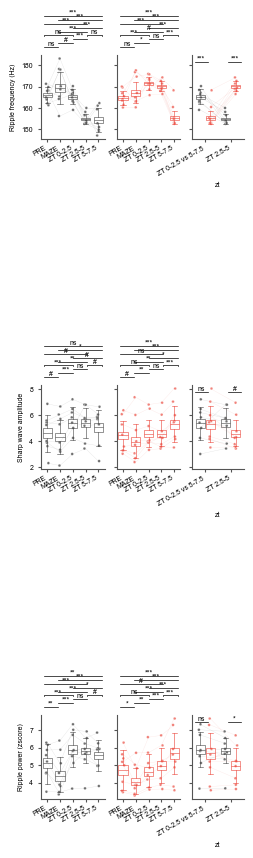

In [16]:
import matplotlib.ticker as ticker

rpl_prop = grpdata.ripple_bootstrap_session_ripples
rpl_prop_sess = grpdata.ripple_features
rpl_sess_mean = (
    rpl_prop_sess.groupby(["grp", "zt", "session"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

fig = subjects.SdFig().fig1(10, 13)
y_labels = [
    "Ripple frequency (Hz)",
    "Sharp wave amplitude",
    "Ripple power (zscore)",
]
colors = subjects.colors_sd(1)
colors_light = subjects.colors_sd_light(1)
ylims = [[145, 185], [2, 8], [3, 8]]
results_list = []
for d, param in enumerate(["peak_freq", "sw_amp", "ripple_power"]):
    fig_row = 3 * d + 1
    subfig = fig.add_subfigure(fig.gs[fig_row : fig_row + 1, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 1.2])
    for g, grp in enumerate(["NSD", "SD"]):
        mean_df = rpl_sess_mean[rpl_sess_mean.grp == grp]
        param_df = rpl_prop[rpl_prop.grp == grp]

        ax = axs[g]

        print(f"\n\033[4m{param} {grp} stats\033[0m:")
        p1 = Plotter(data=param_df, x="zt", y=param, ax=ax)
        results_list.append(p1.boxplot_sd2(palette=[colors[g]], zorder=3).stat_anot(
            stat_within=get_bootstrap_prob_paired,
            alpha_within=[0.025, 0.005, 0.0005],
            fontsize=5,
            verbose=True,
            prepend=(param, grp),
        ))

        p2 = Plotter(data=mean_df, x="zt", y=param, ax=ax)
        p2.striplineplot_sd(palette=[colors_light[g]])

        ax.legend("", frameon=False)
        ax.set_xlabel("")
        if g == 0:
            ax.set_ylabel(y_labels[d])
        else:
            ax.set_ylabel("")
    print(f"\n\033[4m{param} NSD vs SD stats\033[0m:")
    ax = axs[2]
    df = get_nsd_vs_sd_df(rpl_prop)
    df2 = get_nsd_vs_sd_df(rpl_sess_mean)

    p1 = Plotter(data=df, x="zt", y=param, hue="grp", hue_order=["NSD", "SD"], ax=ax)
    results_list.append(p1.boxplot_sd2(palette=colors, zorder=3).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
        prepend=(param, "b/w")
    ))
    p2 = Plotter(data=df2, x="zt", y=param, hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=colors_light)

    ax.set_ylabel("")
    # ax.set_ylim(*ylims[d])

fig.savefig(subjects.figpath_sd / "ripple_properties_boxplots", format="svg")

In [17]:
rpl_prop_sess.groupby(["grp", "session"]).count()

peak_freq  ripple_power  sw_amp  duration  ripple_power_norm  \
grp session                                                                 
NSD 0            19604         19604   19604     19604              19604   
    1            16591         16591   16591     16591              16591   
    2            17482         17482   17482     17482              17482   
    3            15681         15681   15681     15681              15681   
    4            18029         18029   18029     18029              18029   
    5            20303         20303   20303     20303              20303   
    6            18429         18429   18429     18429              18429   
    7            17562         17562   17562     17562              17562   
SD  8            19100         19100   19100     19100              19100   
    9            16359         16359   16359     16359              16359   
    10           17328         17328   17328     17328              17328   
    11           18352         18352   18352     18352              18352   
    12           19612         19612   19612     19612              19612   
    13           24690         24690   24690     24690              24690   
    14           22987         22987   22987     22987              22987   
    15           19536         19536   19536     19536              19536   

             sw_amp_norm     zt  
grp session                      
NSD 0              19604  19604  
    1              16591  16591  
    2              17482  17482  
    3              15681  15681  
    4              18029  18029  
    5              20303  20303  
    6              18429  18429  
    7              17562  17562  
SD  8              19100  19100  
    9              16359  16359  
    10             17328  17328  
    11             18352  18352  
    12             19612  19612  
    13             24690  24690  
    14             22987  22987  
    15             19536  19536

In [18]:
# Calculate total n for each figure that goes into bootstrap, in this case # of ripples
rpl_prop_sess.groupby(["grp"]).count()

,peak_freq,ripple_power,sw_amp,duration,ripple_power_norm,sw_amp_norm,zt,session
grp,,,,,,,,
NSD,143681,143681,143681,143681,143681,143681,143681,143681
SD,157964,157964,157964,157964,157964,157964,157964,157964


In [19]:
results_df = stats_to_df(results_list, prepend = ("param", "grp"))
filter_stats_df(results_df, figure="1")

,param,grp,comp1,comp2,test,pval,test_stat
0,peak_freq,NSD,PRE,MAZE,"get_bootstrap_prob_paired,",1.097e-01,-3.331e+00
1,peak_freq,NSD,MAZE,ZT 0-2.5,"get_bootstrap_prob_paired,",6.510e-02,4.217e+00
2,peak_freq,NSD,ZT 0-2.5,ZT 2.5-5,"get_bootstrap_prob_paired,",0.000e+00,1.045e+01
3,peak_freq,NSD,ZT 2.5-5,ZT 5-7.5,"get_bootstrap_prob_paired,",4.230e-01,4.947e-01
4,peak_freq,NSD,PRE,ZT 0-2.5,"get_bootstrap_prob_paired,",2.971e-01,8.865e-01
6,peak_freq,NSD,ZT 0-2.5,ZT 5-7.5,"get_bootstrap_prob_paired,",0.000e+00,1.095e+01
10,peak_freq,SD,PRE,MAZE,"get_bootstrap_prob_paired,",1.065e-01,-2.301e+00
11,peak_freq,SD,MAZE,ZT 0-2.5,"get_bootstrap_prob_paired,",1.020e-02,-4.396e+00
12,peak_freq,SD,ZT 0-2.5,ZT 2.5-5,"get_bootstrap_prob_paired,",1.402e-01,1.417e+00
13,peak_freq,SD,ZT 2.5-5,ZT 5-7.5,"get_bootstrap_prob_paired,",0.000e+00,1.474e+01


#### Sanity check on unpaired bootstrapping p-value calculation

In [ ]:
# Plot to answer KD question about how we can get a p-value less than 10^4 (n samples) for NSD vs. SD swr-frequency?
rpl_prop = grpdata.ripple_bootstrap_session_ripples
rpl_prop_sess = grpdata.ripple_features
rpl_sess_mean = (
    rpl_prop_sess.groupby(["grp", "zt", "session"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)
df = get_nsd_vs_sd_df(rpl_prop)
df2 = get_nsd_vs_sd_df(rpl_sess_mean)

df_nsd = df[(df.zt == "0-2.5 vs 5-7.5") & (df.grp == "NSD")]
df_sd = df[(df.zt == "0-2.5 vs 5-7.5") & (df.grp == "SD")]

# Code from python package for getting bootstrap probability between two samples below.
sample1 = df_nsd.peak_freq
sample2 = df_sd.peak_freq

sample1 = np.array(sample1)
sample2 = np.array(sample2)

joint_low_val = min([min(sample1), min(sample2)])
joint_high_val = max([max(sample1), max(sample2)])

nbins = 100
p_axis = np.linspace(joint_low_val, joint_high_val, num=nbins)
edge_shift = (p_axis[2] - p_axis[1]) / 2
p_axis_edges = p_axis - edge_shift
p_axis_edges = np.append(p_axis_edges, (joint_high_val + edge_shift))

# Calculate probabilities using histcounts for edges.

p_sample1 = np.histogram(sample1, bins=p_axis_edges)[0] / np.size(sample1)
p_sample2 = np.histogram(sample2, bins=p_axis_edges)[0] / np.size(sample2)

# Now, calculate the joint probability matrix:
# p_joint_matrix = np.zeros((nbins, nbins))
# for i in np.arange(np.shape(p_joint_matrix)[0]):
#     for j in np.arange(np.shape(p_joint_matrix)[1]):
#         p_joint_matrix[i, j] = p_sample1[i] * p_sample2[j]

p_joint_matrix = p_sample1[:, np.newaxis] * p_sample2[np.newaxis, :]

# Normalize the joint probability matrix:
p_joint_matrix = p_joint_matrix / p_joint_matrix.sum()

_, ax = plt.subplots(2, 2)
ax[0, 0].stairs(p_sample1, edges=p_axis_edges)
ax[0, 0].set_xlim((joint_low_val, joint_high_val))
ax[0, 0].set_title('NSD Peak Freq')
ax[1, 1].stairs(p_sample2, edges=p_axis_edges, orientation='horizontal')
ax[1, 1].set_ylim((joint_low_val, joint_high_val))
ax[1, 1].set_title('SD Peak Freq')
ax[1, 0].pcolormesh(p_axis_edges, p_axis_edges, p_joint_matrix.T)
print(p_joint_matrix.reshape(-1).sum())

### EDF 5A: Ripple properties in 1h blocks


peak_freq NSD stats:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

PRE vs. MAZE: get_bootstrap_prob_paired, P_val:1.063e-01 Stat=-3.401e+00
MAZE vs. 0-1: get_bootstrap_prob_paired, P_val:2.932e-01 Stat=-1.331e+00
0-1 vs. 4-5: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=1.755e+01
4-5 vs. 5-6: get_bootstrap_prob_paired, P_val:4.233e-01 Stat=-6.147e-01
PRE vs. 0-1: get_bootstrap_prob_paired, P_val:1.000e-04 Stat=-4.732e+00
MAZE vs. 4-5: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=1.622e+01
0-1 vs. 5-6: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=1.694e+01
PRE vs. 4-5: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=1.282e+01
MAZE vs. 5-6: get_bootstrap_prob_paired, P_val:1.000e-04 Stat=1.561e+01
PRE vs. 5-6: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=1.221e+01

peak_freq SD stats:
p-value annotation legend:
      ns: 1.00e-01 <

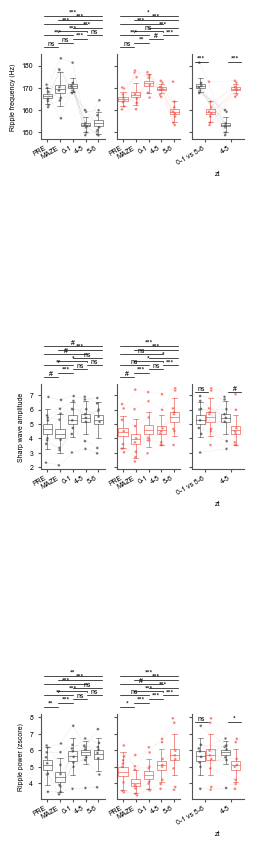

In [20]:
import matplotlib.ticker as ticker

rpl_prop = grpdata.ripple_1h_blocks_bootstrap_session_ripples
rpl_prop_sess = grpdata.ripple_features_1h_blocks
rpl_sess_mean = (
    rpl_prop_sess.groupby(["grp", "zt", "session"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

fig = subjects.SdFig().fig1(10, 13)
y_labels = [
    "Ripple frequency (Hz)",
    "Sharp wave amplitude",
    "Ripple power (zscore)",
]
colors = subjects.colors_sd(1)
colors_light = subjects.colors_sd_light(1)
ylims = [[145, 185], [2, 8], [3, 8]]
for d, param in enumerate(["peak_freq", "sw_amp", "ripple_power"]):
    fig_row = 3 * d + 1
    subfig = fig.add_subfigure(fig.gs[fig_row : fig_row + 1, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 1.2])
    for g, grp in enumerate(["NSD", "SD"]):
        mean_df = rpl_sess_mean[rpl_sess_mean.grp == grp]
        param_df = rpl_prop[rpl_prop.grp == grp]

        ax = axs[g]

        print(f"\n\033[4m{param} {grp} stats\033[0m:")
        p1 = Plotter(data=param_df, x="zt", y=param, ax=ax)
        p1.boxplot_sd2(palette=[colors[g]], zorder=3).stat_anot(
            stat_within=get_bootstrap_prob_paired,
            alpha_within=[0.025, 0.005, 0.0005],
            fontsize=5,
            verbose=True,
        )

        p2 = Plotter(data=mean_df, x="zt", y=param, ax=ax)
        p2.striplineplot_sd(palette=[colors_light[g]])

        ax.legend("", frameon=False)
        ax.set_xlabel("")
        if g == 0:
            ax.set_ylabel(y_labels[d])
        else:
            ax.set_ylabel("")
    print(f"\n\033[4m{param} NSD vs SD stats\033[0m:")
    ax = axs[2]
    df = get_nsd_vs_sd_df(rpl_prop, block_size=1)
    df2 = get_nsd_vs_sd_df(rpl_sess_mean, block_size=1)

    p1 = Plotter(data=df, x="zt", y=param, hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p1.boxplot_sd2(palette=colors, zorder=3).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )
    p2 = Plotter(data=df2, x="zt", y=param, hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=colors_light)

    ax.set_ylabel("")
    # ax.set_ylim(*ylims[d])

fig.savefig(subjects.figpath_sd / "ripple_properties_boxplots_1h_blocks", format="svg")

### Normalized ripple properties
- subtracting mean of PRE from each block

In [ ]:
import matplotlib.ticker as ticker

rpl_prop_norm = grpdata.ripple_normalized_bootstrap_session_ripples

# --- normalization by subtracting mean_pre -----
# rpl_prop_norm = rpl_prop.copy()
# column_bool = rpl_prop_norm.columns.isin(["grp", "zt", "session"])

# for g, grp in enumerate(["NSD", "SD"]):
#     mean_pre = rpl_prop_norm.loc[
#         (rpl_prop_norm.grp == grp) & (rpl_prop_norm.zt == "PRE"), ~column_bool
#     ].mean()
#     rpl_prop_norm.loc[rpl_prop_norm.grp == grp, ~column_bool] = (
#         rpl_prop_norm.loc[rpl_prop_norm.grp == grp, ~column_bool] - mean_pre
#     )


rpl_prop_sess = grpdata.ripple_features_normalized
rpl_sess_mean = (
    rpl_prop_sess.groupby(["grp", "zt", "session"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

# for g, grp in enumerate(["NSD", "SD"]):
#     mean_pre = rpl_sess_mean.loc[
#         (rpl_sess_mean.grp == grp) & (rpl_sess_mean.zt == "PRE"), ~column_bool
#     ].mean()
#     rpl_sess_mean.loc[rpl_sess_mean.grp == grp, ~column_bool] = (
#         rpl_sess_mean.loc[rpl_sess_mean.grp == grp, ~column_bool] - mean_pre
#     )


fig = subjects.SdFig().fig1(10, 13)
y_labels = [
    "Ripple frequency (Hz)",
    "Sharp wave amplitude",
    "Ripple power (zscore)",
]
colors = subjects.colors_sd(1)
colors_light = subjects.colors_sd_light(1)
ylims = [[145, 185], [2, 8], [3, 8]]
for d, param in enumerate(["peak_freq", "sw_amp", "ripple_power"]):
    fig_row = 3 * d + 1
    subfig = fig.add_subfigure(fig.gs[fig_row : fig_row + 1, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 1.2])
    for g, grp in enumerate(["NSD", "SD"]):
        mean_df = rpl_sess_mean[rpl_sess_mean.grp == grp]
        param_df = rpl_prop_norm[rpl_prop_norm.grp == grp]

        ax = axs[g]

        print(f"\n\033[4m{param} {grp} stats\033[0m:")
        p1 = Plotter(data=param_df, x="zt", y=param, ax=ax)
        p1.boxplot_sd2(palette=[colors[g]], zorder=3).stat_anot(
            stat_within=get_bootstrap_prob_paired,
            alpha_within=[0.025, 0.005, 0.0005],
            fontsize=5,
            verbose=True,
        )

        p2 = Plotter(data=mean_df, x="zt", y=param, ax=ax)
        p2.striplineplot_sd(palette=[colors_light[g]])

        ax.legend("", frameon=False)
        ax.set_xlabel("")
        if g == 0:
            ax.set_ylabel(y_labels[d])
        else:
            ax.set_ylabel("")

    print(f"\n\033[4m{param} NSD v SD stats\033[0m:")
    ax = axs[2]
    df = get_nsd_vs_sd_df(rpl_prop_norm)
    df2 = get_nsd_vs_sd_df(rpl_sess_mean)

    p1 = Plotter(data=df, x="zt", y=param, hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p1.boxplot_sd2(palette=colors, zorder=3).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )
    p2 = Plotter(data=df2, x="zt", y=param, hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=colors_light)

    ax.set_ylabel("")
    # ax.set_ylim(*ylims[d])

fig.savefig(subjects.figpath_sd / "ripple_properties_normalized", format="svg")

### EDF 6A: Ripple properties in 1h blocks
See sd_figure3_supp.ipynb